In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')

In [2]:
img_path = '../input_videos/image.png'

1204 2471


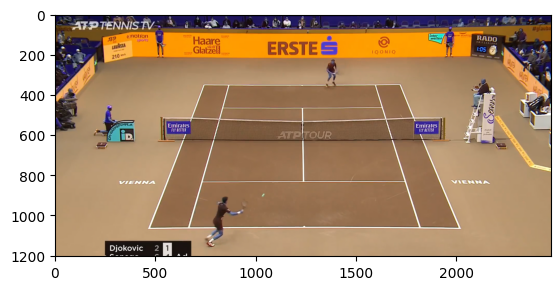

In [20]:
img = cv2.imread(img_path)
plt.imshow(img)

height, width = img.shape[:2]
print(height, width)

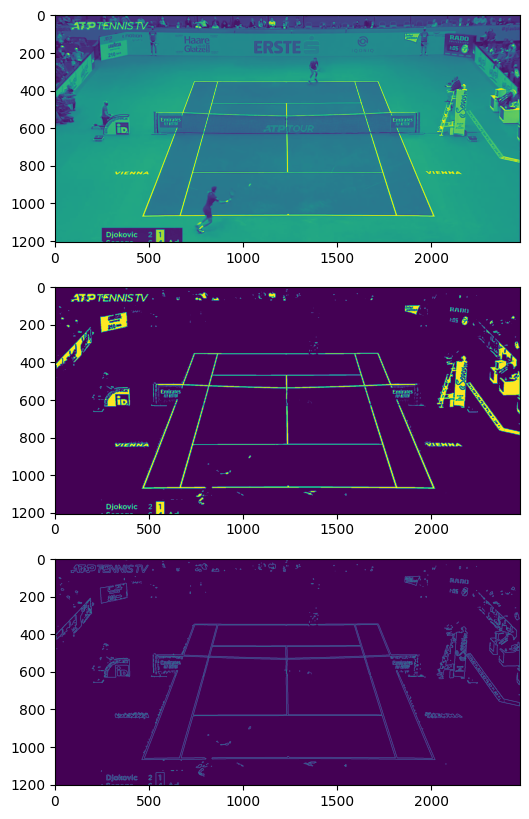

In [12]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bw = cv2.threshold(gray, 156, 255, cv2.THRESH_BINARY)[1]
canny = cv2.Canny(bw, 100, 200)
cannyP = np.copy(canny)

plt.subplots(3, 1, figsize=(10, 10))
plt.subplot(311)
plt.imshow(gray)
plt.subplot(312)
plt.imshow(bw)
plt.subplot(313)
plt.imshow(canny)

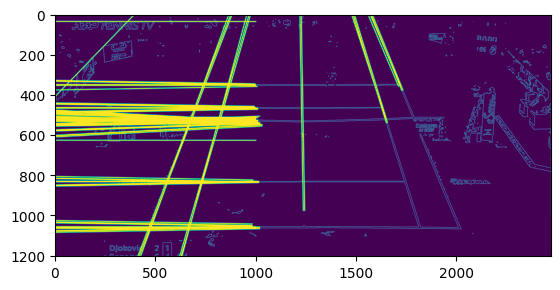

In [13]:
lines = cv2.HoughLines(canny, 1, np.pi/180, 150, None, 0, 0)

if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        cv2.line(canny, pt1, pt2, (255, 0, 0), 3, cv2.LINE_AA)

plt.imshow(canny)

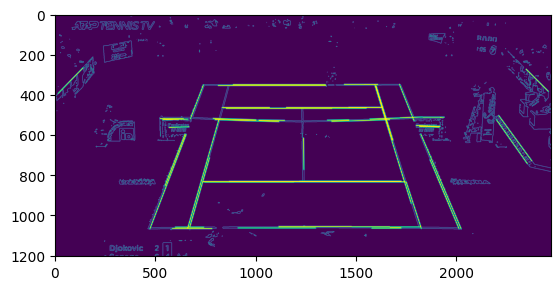

In [14]:
hp_lines = cv2.HoughLinesP(cannyP, 1, np.pi/180, 150, None, 100, 10)

if hp_lines is not None:
    for i in range(len(hp_lines)):
        l = hp_lines[i][0]
        cv2.line(cannyP, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 3, cv2.LINE_AA)

plt.imshow(cannyP)

In [15]:
def determinant(a, b):
    return a[0] * b[1] - a[1] * b[0]

def find_intersection(line1, line2, x_start, y_start, x_end, y_end):
    x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    div = determinant(x_diff, y_diff)

    if div == 0:
        return None
    
    d = (determinant(*line1), determinant(*line2))
    x = int(determinant(d, x_diff) / div)
    y = int(determinant(d, y_diff) / div)

    if (x < x_start) or (x > x_end):
        return None
    if (y < y_start) or (y > y_end):
        return None
    
    return x, y

(54, 2)


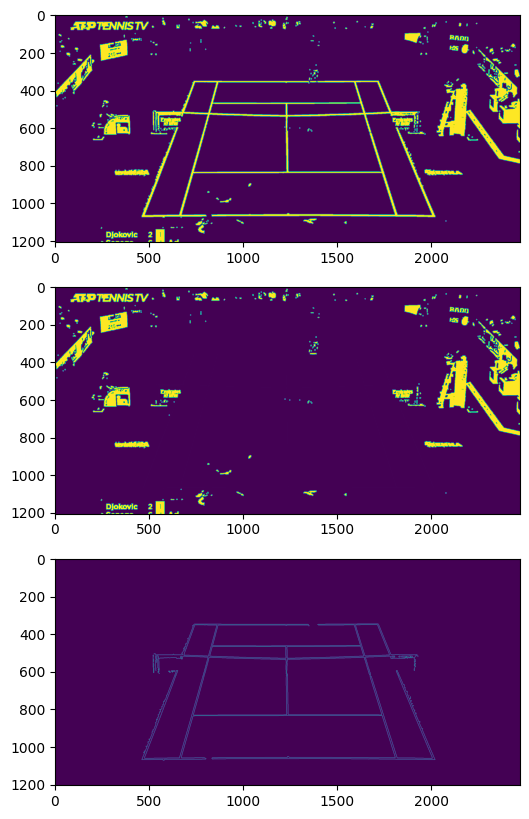

In [60]:
intersect_num = np.zeros((len(hp_lines), 2))

i = 0

for hp_line1 in hp_lines:
    line1_x1, line1_y1, line1_x2, line1_y2 = hp_line1[0]
    line1 = [[line1_x1, line1_y1], [line1_x2, line1_y2]]

    for hp_line2 in hp_lines:
        line2_x1, line2_y1, line2_x2, line2_y2 = hp_line2[0]
        line2 = [[line2_x1, line2_y1], [line2_x2, line2_y2]]

        if line1 is line2:
            continue
        if line1_x1 > line1_x2:
            temp = line1_x1
            line1_x1 = line1_x2
            line1_x2 = temp

        if line1_y1 > line1_y2:
            temp = line1_y1
            line1_y1 = line1_y2
            line1_y2 = temp

        intersect = find_intersection(line1, line2, line1_x1 - 200, line1_y1 - 200, line1_x2 + 200, line1_y2 + 200)
        if intersect is not None:
            intersect_num[i][0] += 1
    intersect_num[i][1] = i
    i += 1

print(intersect_num.shape)

# Lines with most intersections get a fill mask command on them
i = p = 0
dilation = cv2.dilate(bw, np.ones((5, 5), np.uint8), iterations=1)
non_rect_area = dilation.copy()
intersect_num = intersect_num[(-intersect_num)[:, 0].argsort()]

plt.subplots(3, 1, figsize=(10, 10))
plt.subplot(311)
plt.imshow(dilation)
g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t = cv2.threshold(g, 156, 255, cv2.THRESH_BINARY)[1]
can = cv2.Canny(t, 100, 200)
for hp_line in hp_lines:
    x1, y1, x2, y2 = hp_line[0]
    # cv2.line(can, (x1, y1), (x2, y2), (255, 255, 0), 2)
    
    for p in range(2):
        if (i == intersect_num[p][1]) and (intersect_num[i][0] > 0):
            cv2.line(can, (x1, y1), (x2, y2), (255, 0, 255), 2)
            cv2.floodFill(non_rect_area, np.zeros((height + 2, width + 2), np.uint8), (x1, y1), 1)
            cv2.floodFill(non_rect_area, np.zeros((height + 2, width + 2), np.uint8), (x2, y2), 1)
    i += 1

plt.subplot(312)
plt.imshow(non_rect_area)
dilation[np.where(non_rect_area == 255)] = 0
dilation[np.where(non_rect_area == 1)] = 255
eroded = cv2.erode(dilation, np.ones((5, 5), np.uint8))
canny_main = cv2.Canny(eroded, 90, 100)
plt.subplot(313)
plt.imshow(canny_main)
